Importing all required Libraries and packages for the model building and data

In [0]:
!pip install scikit-learn
!pip install 'nltk==3.4.5'

     |████████████████████████████████| 1.5MB 2.8MB/s 
  Created wheel for nltk: filename=nltk-3.4.5-cp36-none-any.whl size=1449908 sha256=c6648cbb995538a710ec7b057013e354ab529487ff3820018940e4d9a40e6156
  Stored in directory: /root/.cache/pip/wheels/96/86/f6/68ab24c23f207c0077381a5e3904b2815136b879538a24b483
Successfully built nltk
  Found existing installation: nltk 3.2.5
    Uninstalling nltk-3.2.5:
      Successfully uninstalled nltk-3.2.5


In [0]:
import re
from sklearn.model_selection import train_test_split

In [0]:
import tensorflow as tf
from tensorflow import keras
import pandas as pd
import numpy as np
import nltk
from nltk import word_tokenize
from keras import Sequential
from keras.layers import Embedding, LSTM, Dense, Dropout
from keras.preprocessing import sequence
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import one_hot
from tensorflow.keras import layers
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D

Now, we will get our dataset from Drive

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
path = "drive/My Drive/Colab Dataset/IMDB-Dataset.csv"
IMDBFull = pd.read_csv(path)

Clearing the data of unwanted spaces and other symbols

In [0]:
def preprocess_text(sen):
    # Removing html tags
    sentence = remove_tags(sen)

    # Remove punctuations and numbers
    sentence = re.sub('[^a-zA-Z]', ' ', sentence)

    # Single character removal
    sentence = re.sub(r"\s+[a-zA-Z]\s+", ' ', sentence)

    # Removing multiple spaces
    sentence = re.sub(r'\s+', ' ', sentence)

    return sentence

In [0]:
TAG_RE = re.compile(r'<[^>]+>')

def remove_tags(text):
    return TAG_RE.sub('', text)

In [0]:
X = []
sentences = list(IMDBFull['review'])
for sen in sentences:
    X.append(preprocess_text(sen))

Defining the sentiments as 1 for Positive and 0 for negative

In [0]:
y = IMDBFull['sentiment']

y = np.array(list(map(lambda x: 1 if x=="positive" else 0, y)))

Train Test split

In [0]:
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2)

In [0]:
X_train,X_val,y_train,Y_val=train_test_split(X_train,y_train,test_size=0.375)

In [0]:
tokenizer = Tokenizer(num_words=3000)
tokenizer.fit_on_texts(X_train)

X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)
X_val=tokenizer.texts_to_sequences(X_val)

Padding to define a set limit of the input sequences.

In [0]:
max_words = 300
X_train = sequence.pad_sequences(X_train, maxlen=max_words)
X_test = sequence.pad_sequences(X_test, maxlen=max_words)
X_val = sequence.pad_sequences(X_val, maxlen=max_words)

We will create a LSTM model just like the single LSTM in previous part of first question. Only this time, we have also added the Convolutional layer before the LSTM. So as to compare it's effect on the previous Model's performance.

In [0]:
embedding_length = 64
model = Sequential()
model.add(Embedding(num_words, embedding_length, input_length=max_words))
model.add(Conv1D(filters=64, kernel_size=5, activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(LSTM(256, dropout=0.1))
model.add(Dropout(0.1))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())

Model: "sequential_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_13 (Embedding)     (None, 300, 64)           192000    
_________________________________________________________________
conv1d_14 (Conv1D)           (None, 296, 64)           20544     
_________________________________________________________________
max_pooling1d_11 (MaxPooling (None, 148, 64)           0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 256)               328704    
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_10 (Dense)             (None, 1)                 257       
Total params: 541,505
Trainable params: 541,505
Non-trainable params: 0
_______________________________________________

In [0]:
history = model.fit(X_train, y_train, validation_data=(X_val, Y_val), epochs=5, batch_size=64)

Train on 25000 samples, validate on 15000 samples
Epoch 1/5
25000/25000 [==============================] - 431s 17ms/step - loss: 0.4335 - accuracy: 0.7901 - val_loss: 0.3150 - val_accuracy: 0.8648
Epoch 2/5
25000/25000 [==============================] - 400s 16ms/step - loss: 0.2673 - accuracy: 0.8935 - val_loss: 0.2811 - val_accuracy: 0.8833
Epoch 3/5
25000/25000 [==============================] - 400s 16ms/step - loss: 0.2356 - accuracy: 0.9084 - val_loss: 0.3002 - val_accuracy: 0.8825
Epoch 4/5
25000/25000 [==============================] - 401s 16ms/step - loss: 0.2086 - accuracy: 0.9210 - val_loss: 0.2886 - val_accuracy: 0.8846
Epoch 5/5
25000/25000 [==============================] - 406s 16ms/step - loss: 0.1718 - accuracy: 0.9361 - val_loss: 0.2883 - val_accuracy: 0.8856


In [0]:
scores = model.evaluate(X_test, y_test, verbose=1)
print("Test Loss:", scores[0])
print("Test Accuracy:", scores[1])

10000/10000 [==============================] - 44s 4ms/step
Test Loss: 0.2924002163648605
Test Accuracy: 0.8794000148773193


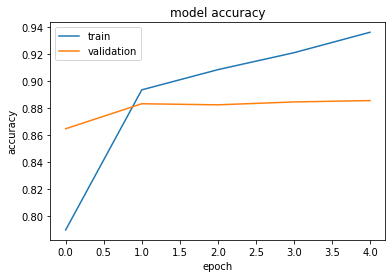

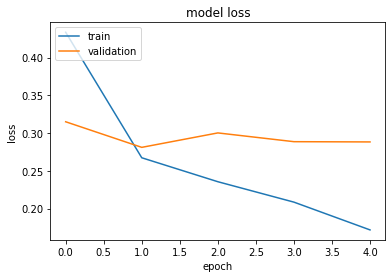

In [0]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','validation'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','validation'], loc='upper left')
plt.show()

Saving model to local drive

In [0]:
!pip install h5py
model.save('Q1CNN-LSTM.h5')

In [0]:
from google.colab import files
files.download("Q1CNN-LSTM.h5")